# MNIST Digit Classification - RNN

In [1]:
from __future__ import division, print_function
from tensorflow.contrib import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

LOG_DIR = os.path.join(DATA_DIR, "tf-mnist-rnn-logs")
MODEL_FILE = os.path.join(DATA_DIR, "tf-mnist-rnn")

IMG_SIZE = 28
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append(np.reshape(
            np.array([float(x) / 255. for x in cols[1:]]),
            (IMG_SIZE, IMG_SIZE)))
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    y = np.array(ydata).astype("float32")
    X = np.array(xdata).astype("float32")
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, X.shape[1], X.shape[2]), 
                              dtype="float32")
            Ybatch = np.zeros((batch_size, num_classes), dtype="float32")
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Xbatch.dtype, Ybatch.shape, Ybatch.dtype)

(128, 28, 28) float32 (128, 10) float32


## Define Network

In [5]:
X = tf.placeholder(tf.float32, [BATCH_SIZE, IMG_SIZE, IMG_SIZE], name="X")
Y = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES], name="Y")

In [6]:
# Current data input shape: (batch_size, n_steps, n_input)
# Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
x = tf.unstack(X, IMG_SIZE, 1)
lstm_cell = tf.contrib.rnn.BasicLSTMCell(512)
lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, x, 
                                                      dtype=tf.float32)
# # Linear activation, using rnn inner loop last output
lstm_ctx = lstm_outputs[-1]

# dropout
H1 = tf.nn.dropout(lstm_ctx, 0.2)

# Fully connected layer
W = tf.Variable(tf.truncated_normal(shape=[512, NUM_CLASSES], 
                                    stddev=0.01))
b = tf.Variable(tf.zeros(shape=[NUM_CLASSES]))
Y_ = tf.nn.softmax(tf.add(tf.matmul(H1, W), b))

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=Y_, labels=Y))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

In [8]:
correct_preds = tf.equal(tf.argmax(Y_, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [9]:
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
# Merge all summaries into a single op
summary_op = tf.summary.merge_all()

## Train Network

In [10]:
history = []
sess = tf.Session()
with sess.as_default():
    
    # shuts off "harmless warning", see
    # https://github.com/tensorflow/tensorflow/issues/9939
    if (tf.get_collection_ref("LAYER_NAME_UIDS") is not None and 
            len(tf.get_collection_ref("LAYER_NAME_UIDS")) > 0):
        del tf.get_collection_ref('LAYER_NAME_UIDS')[0]

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    logger = tf.summary.FileWriter(LOG_DIR, sess.graph)

    train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
    num_batches = len(Xtrain) // BATCH_SIZE
    for epoch in range(NUM_EPOCHS):
        total_loss, total_acc = 0., 0.
        for bid in range(num_batches):
            # train
            Xbatch, Ybatch = train_gen.next()
            _, batch_loss, batch_acc, Ybatch_, summary = sess.run(
                [optimizer, loss, accuracy, Y_, summary_op], 
                feed_dict={X: Xbatch, Y:Ybatch})
            # write to tensorboard
            logger.add_summary(summary, epoch * num_batches + bid)
            # accumulate for reporting
            total_loss += batch_loss
            total_acc += batch_acc

        total_loss /= num_batches
        total_acc /= num_batches
        print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch + 1), NUM_EPOCHS, total_loss, total_acc))
        
        saver.save(sess, MODEL_FILE, (epoch + 1))
        history.append((total_loss, total_acc))
        
    logger.close()

Epoch 1/5: loss=1.797, accuracy=0.670
Epoch 2/5: loss=1.584, accuracy=0.879
Epoch 3/5: loss=1.542, accuracy=0.920
Epoch 4/5: loss=1.525, accuracy=0.936
Epoch 5/5: loss=1.512, accuracy=0.949


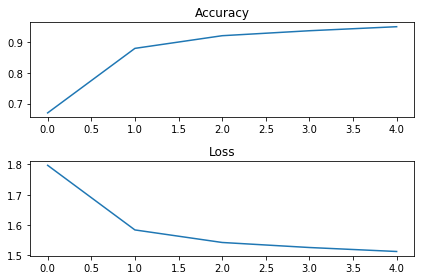

In [11]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Visualize with Tensorboard

We have also requested the total_loss and total_accuracy scalars to be logged in our computational graph, so the above charts can also be seen from the built-in tensorboard tool. The scalars are logged to the directory given by LOG_DIR, so we can start the tensorboard tool from the command line:

    $ cd ../../data
    $ tensorboard --logdir=tf-mnist-rnn-logs
    Starting TensorBoard 54 at http://localhost:6006
    (Press CTRL+C to quit)
    
We can then view the [visualizations on tensorboard] (http://localhost:6006)

## Evaluate Network

In [12]:
BEST_MODEL = os.path.join(DATA_DIR, "tf-mnist-rnn-5")
saver = tf.train.Saver()
ys, ys_ = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, BEST_MODEL)
    test_gen = datagen(Xtest, ytest, BATCH_SIZE)
    val_loss, val_acc = 0., 0.
    num_batches = len(Xtrain) // BATCH_SIZE
    for _ in range(num_batches):
        Xbatch, Ybatch = test_gen.next()
        Ybatch_ = sess.run(Y_, feed_dict={X: Xbatch, Y:Ybatch})
        ys.extend(np.argmax(Ybatch, axis=1))
        ys_.extend(np.argmax(Ybatch_, axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

INFO:tensorflow:Restoring parameters from ../../data/tf-mnist-rnn-5
Accuracy: 0.9542
Confusion Matrix
[[5648    0   35    0   21   12    2   16   23   63]
 [   1 6588    6    0    0    6   13   15    0    3]
 [   1   29 5893   73   29    6    7   66    7    0]
 [   0    6   35 5600    0    3    0    8    6    0]
 [  19    0    0   16 5551    9   41    9   60  130]
 [  25    0   52  183    4 5262   58   12  100   88]
 [ 160   24   30    0  137   21 5610    0   57    2]
 [   6   47   82   63    0    8    0 5955    0   39]
 [   6  103   47   95   38   12    4   24 5583  250]
 [   3    0    1   23  107    6    5   48    0 5468]]
